# Bikeshare rides (Winter 2018)
This notebook analyzes bikeshare data for NYC citibikes. 

Here we get some of the bike data (Jan - Mar of 2018) as a sample set and perform some basic exploratory analysis and plot-making

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm



from mpl_toolkits.basemap import Basemap


In [2]:
#Grab the data for winder 2018
winter_df_list = []

for el in ['01','02','03']:
    winter_df_list.append(pd.read_csv('../data/NYC/2018/2018{}-citibike-tripdata/2018{}-citibike-tripdata.csv'.format(el,el)))

winter_df_list[0].head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72,W 52 St & 11 Ave,40.767272,-73.993929,505,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72,W 52 St & 11 Ave,40.767272,-73.993929,3255,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72,W 52 St & 11 Ave,40.767272,-73.993929,525,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72,W 52 St & 11 Ave,40.767272,-73.993929,447,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72,W 52 St & 11 Ave,40.767272,-73.993929,3356,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1


In [5]:
#Concat them all together into one dataframe
winter_df = pd.concat(winter_df_list,ignore_index=True)
winter_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72,W 52 St & 11 Ave,40.767272,-73.993929,505,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72,W 52 St & 11 Ave,40.767272,-73.993929,3255,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72,W 52 St & 11 Ave,40.767272,-73.993929,525,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72,W 52 St & 11 Ave,40.767272,-73.993929,447,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72,W 52 St & 11 Ave,40.767272,-73.993929,3356,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1


In [6]:
winter_df.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,2.538780e+06,2.538780e+06,2.538780e+06,2.538780e+06,2.538780e+06,2.538780e+06,2.538780e+06,2.538780e+06,2.538780e+06,2.538780e+06
mean,8.648393e+02,1.483742e+03,4.073769e+01,-7.398306e+01,1.473223e+03,4.073737e+01,-7.398335e+01,2.618555e+04,1.977943e+03,1.163310e+00
std,3.123193e+04,1.406269e+03,3.700593e-02,1.810140e-02,1.403815e+03,3.676187e-02,1.816684e-02,6.217588e+03,1.209395e+01,4.898546e-01
min,6.100000e+01,7.200000e+01,4.064654e+01,-7.401713e+01,7.200000e+01,4.064654e+01,-7.405570e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,3.210000e+02,3.770000e+02,4.071901e+01,-7.399468e+01,3.690000e+02,4.071901e+01,-7.399490e+01,1.980600e+04,1.969000e+03,1.000000e+00
50%,5.210000e+02,4.980000e+02,4.073932e+01,-7.398584e+01,4.970000e+02,4.073913e+01,-7.398658e+01,2.841800e+04,1.980000e+03,1.000000e+00
75%,8.750000e+02,3.173000e+03,4.075669e+01,-7.397484e+01,3.172000e+03,4.075641e+01,-7.397520e+01,3.155300e+04,1.988000e+03,1.000000e+00
max,1.951005e+07,3.674000e+03,4.550636e+01,-7.356891e+01,3.674000e+03,4.550636e+01,-7.356891e+01,3.355100e+04,2.002000e+03,2.000000e+00


In [20]:
#Number of weekend days and weekday days for Jan - March 2018
num_WE = 25
num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

The next few cells use the functions in `bike_share_functions.py` to clean the bike data and assemble an independent station dataframe and export pickled versions of the various dataframes.

In particular, `bike_clean_df` does the f non-subscribers, 


In [22]:
import sys
sys.path.append('../')

from bike_share_functions import bike_clean_df

subs_df = bike_clean_df(winter_df)

In [23]:
from bike_share_functions import get_stations_info

stations_info_df = get_stations_info(subs_df)
print(len(stations_info_df)) # get the number of stations
stations_info_df.head()


777


,lat,lon,station name
72,40.767272,-73.993929,W 52 St & 11 Ave
79,40.719116,-74.006667,Franklin St & W Broadway
82,40.711174,-74.000165,St James Pl & Pearl St
83,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl
119,40.696089,-73.978034,Park Ave & St Edwards St


In [24]:
from bike_share_functions import get_trip_info

subs_trips_df = get_trip_info(subs_df)

subs_trips_df.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,start_day,stop_day,pickup_hour,dropoff_hour,age,Trip_Type,start_end_station
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,505,31956,Subscriber,1992,1,0,0,13,14,26,Daytime Errand,"(72, 505)"
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,3255,32536,Subscriber,1969,1,0,0,15,15,49,Daytime Errand,"(72, 3255)"
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,525,16069,Subscriber,1956,1,0,0,15,15,62,Daytime Errand,"(72, 525)"
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,447,31781,Subscriber,1974,1,0,0,15,15,44,Daytime Errand,"(72, 447)"
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,3356,30319,Subscriber,1992,1,0,0,18,18,26,Commuter,"(72, 3356)"


In [8]:
#Export the results as pickled dateframes for use in other analyses 
subs_df.to_pickle('../data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df.to_pickle('../data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df.to_pickle('../data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')

In [25]:
#Separate out the weekday and weekend trips
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [26]:
weekend_subs_trips_df.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,start_day,stop_day,pickup_hour,dropoff_hour,age,Trip_Type,start_end_station
116,1347,2018-01-06 11:12:20.973,2018-01-06 11:34:48.773,72,382,18783,Subscriber,1968,1,5,5,11,11,50,Weekend,"(72, 382)"
117,471,2018-01-06 11:43:53.488,2018-01-06 11:51:44.696,72,479,25288,Subscriber,1992,1,5,5,11,11,26,Weekend,"(72, 479)"
118,304,2018-01-06 17:15:05.323,2018-01-06 17:20:09.783,72,515,32352,Subscriber,1974,1,5,5,17,17,44,Weekend,"(72, 515)"
119,374,2018-01-07 12:42:24.651,2018-01-07 12:48:38.807,72,450,16988,Subscriber,1983,1,6,6,12,12,35,Weekend,"(72, 450)"
120,334,2018-01-07 13:48:19.772,2018-01-07 13:53:54.086,72,173,31484,Subscriber,1977,1,6,6,13,13,41,Weekend,"(72, 173)"


The following are just simple plots of various aspects of the data

Text(0.5, 1.0, 'Total Trips per Hour (weekdays)')

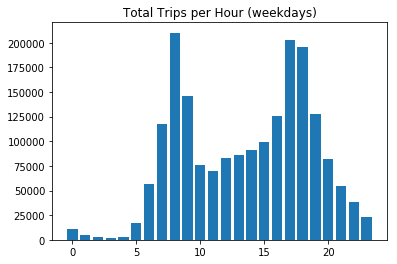

In [180]:
#Total trips (= num pickups) by hour (weekday)
fig = plt.figure()
ax = fig.gca()

total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['starttime'].count()

ax.bar(total_rides_by_hour.index,total_rides_by_hour)
ax.set_title('Total Trips per Hour (weekdays)')


Text(0.5, 1.0, 'Total Trips per Hour (weekends)')

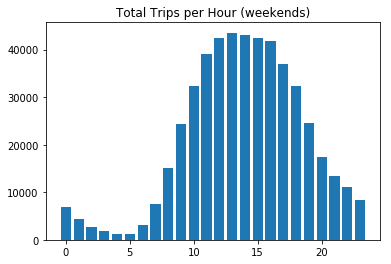

In [181]:
#Total trips by hour (weekend)
fig = plt.figure()
ax = fig.gca()

total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['starttime'].count()

ax.bar(total_rides_by_hour.index,total_rides_by_hour)
ax.set_title('Total Trips per Hour (weekends)')

In [32]:
max_pu_st

519

Text(0.5, 1.0, 'Pickups per hour for top (hourly) weekday station \n (station #519: Pershing Square North)')

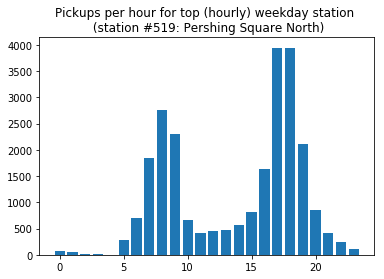

In [182]:
plt.figure() 
ax = plt.gca()

total_rides_by_hr_st = weekday_subs_trips_df.groupby(['pickup_hour','start station id'])['tripduration'].count()
total_rides_by_hr_st = total_rides_by_hr_st.rename('total_trips') 

max_pu_st = total_rides_by_hr_st.idxmax()[1]

top_pu_station = total_rides_by_hr_st.loc[:,max_pu_st]


ax.bar(top_pu_station.index,top_pu_station)
#ax.set_title('Pickups per hour for top (hourly) station (weekday)')
ax.set_title('Pickups per hour for top (hourly) weekday station \n (station #{}: {})'.format(max_pu_st,stations_info_df.loc[max_pu_st]['station name']))


#plt.bar(top_do_station.index,top_do_station)

Text(0.5, 1.0, 'Pickups per hour for top (hourly) station (weekend) \n (station #435: W 21 St & 6 Ave)')

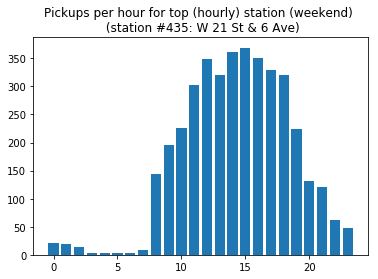

In [183]:
#Hourly pickups for station with max trips in any given hour
plt.figure() 
ax = plt.gca()

total_rides_by_hr_st = weekend_subs_trips_df.groupby(['pickup_hour','start station id'])['tripduration'].count()
total_rides_by_hr_st = total_rides_by_hr_st.rename('total_trips') 

max_pu_st = total_rides_by_hr_st.idxmax()[1]

top_pu_station = total_rides_by_hr_st.loc[:,max_pu_st]


ax.bar(top_pu_station.index,top_pu_station)
#ax.set_title('Pickups per hour for top (hourly) weekend station')
ax.set_title('Pickups per hour for top (hourly) station (weekend) \n (station #{}: {})'.format(max_pu_st,stations_info_df.loc[max_pu_st]['station name']))

#plt.bar(top_do_station.index,top_do_station)

Text(0.5, 1.0, 'Average trip duration by hour (weekday)')

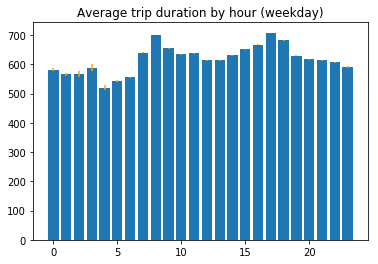

In [184]:
fig = plt.figure()
ax = fig.gca()


avg_duration_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].mean()

total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].count()
yerror = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].std()/(total_rides_by_hour)**(1/2)

ax.bar(avg_duration_by_hour.index,avg_duration_by_hour, yerr=yerror,ecolor = 'orange')
ax.set_title('Average trip duration by hour (weekday)')

Text(0.5, 1.0, 'Average trip duration by hour (weekend)')

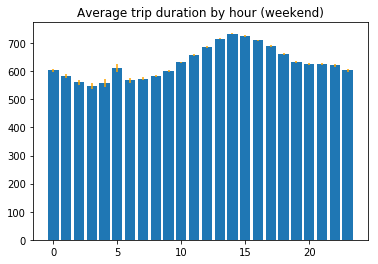

In [185]:
fig = plt.figure()
ax = fig.gca()

avg_duration_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].mean()

total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].count()
yerror = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].std()/(total_rides_by_hour)**(1/2)
#yerror = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].std()/avg_duration_by_hour

ax.bar(avg_duration_by_hour.index,avg_duration_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Average trip duration by hour (weekend)')

Text(0.5, 1.0, 'Average age by hour (weekday)')

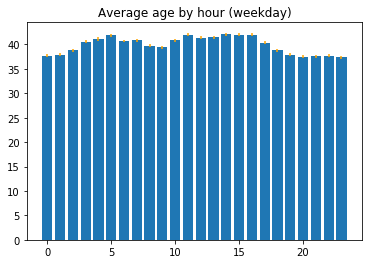

In [186]:
fig = plt.figure()
ax = fig.gca()

avg_age_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['age'].mean()

total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['age'].count()
#yerror = weekday_subs_trips_df.groupby('pickup_hour')['age'].std()/(total_rides_by_hour)**(1/2)
yerror = weekday_subs_trips_df.groupby('pickup_hour')['age'].std()/avg_age_by_hour #Relative standard deviation instead of std dev of mean

ax.bar(avg_age_by_hour.index,avg_age_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Average age by hour (weekday)')

Text(0.5, 1.0, 'Average age by hour (weekend)')

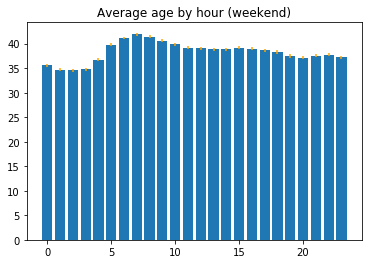

In [187]:
fig = plt.figure()
ax = fig.gca()

avg_age_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['age'].mean()

total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['age'].count()
#yerror = weekend_subs_trips_df.groupby('pickup_hour')['age'].std()/(total_rides_by_hour)**(1/2)
yerror = weekend_subs_trips_df.groupby('pickup_hour')['age'].std()/avg_age_by_hour

ax.bar(avg_age_by_hour.index,avg_age_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Average age by hour (weekend)')

Text(0.5, 1.0, 'Trip duration histogram (weekday)')

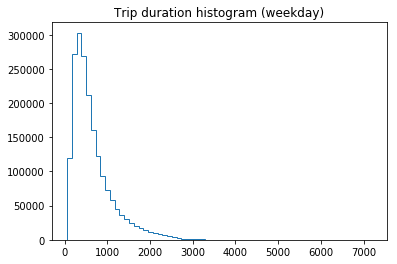

In [217]:
fig = plt.figure()
ax = fig.gca()


weekday_subs_trips_df['tripduration'].hist(bins=64,histtype='step')
ax.grid(False)

ax.set_title('Trip duration histogram (weekday)')

Text(0.5, 1.0, 'Trip duration histogram (weekend)')

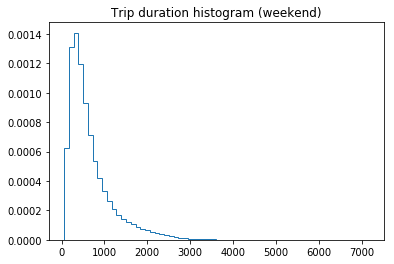

In [189]:
fig = plt.figure()
ax = fig.gca()


weekend_subs_trips_df['tripduration'].hist(bins=64,histtype='step',density=True)

ax.grid(False)

ax.set_title('Trip duration histogram (weekend)')

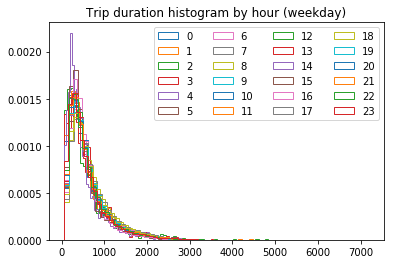

In [190]:
fig = plt.figure()
ax = fig.gca()


duration_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration']

duration_by_hour.hist(bins=64,histtype ='step',density=True)
#ax.hist(duration_by_hour)

#ax.bar(avg_duration_by_hour.index,avg_duration_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Trip duration histogram by hour (weekday)')

ax.grid(False)
ax.legend(labels = list(range(24)),ncol=4)

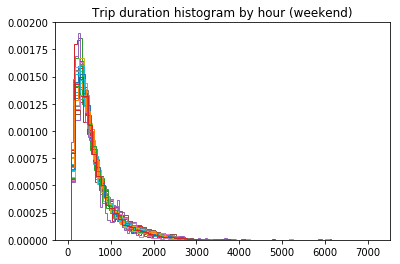

In [191]:
fig = plt.figure()
ax = fig.gca()


duration_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration']

duration_by_hour.hist(bins=64,histtype='step',density=True)
#ax.hist(duration_by_hour)

#ax.bar(avg_duration_by_hour.index,avg_duration_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Trip duration histogram by hour (weekend)')
ax.grid(False)
#ax.legend(labels = list(range(24)),ncol=4)

Text(0.5, 1.0, 'Age histogram (weekday)')

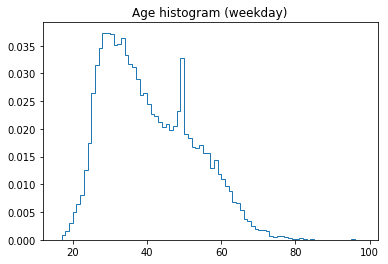

In [192]:
fig = plt.figure()
ax = fig.gca()


ages_series  = weekday_subs_trips_df[weekday_subs_trips_df['age'] < 100]['age']
#duration_by_hour = short_weekend_subs_trips_df.groupby('pickup_hour')['tripduration']

ages_series.hist(bins=list([n for n in range(ages_series.min(),ages_series.max())]),histtype='step',density=True)
#ax.hist(duration_by_hour)

ax.grid(False)
#ax.bar(avg_duration_by_hour.index,avg_duration_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Age histogram (weekday)')
#ax.legend(labels = list(range(24)),ncol=4)

Text(0.5, 1.0, 'Age histogram (weekend)')

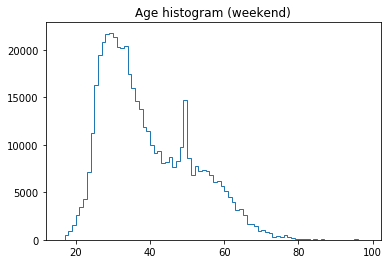

In [205]:
fig = plt.figure()
ax = fig.gca()


ages_series  = weekend_subs_trips_df[weekend_subs_trips_df['age'] < 100]['age']
#duration_by_hour = short_weekend_subs_trips_df.groupby('pickup_hour')['tripduration']

ages_series.hist(bins=list([n for n in range(ages_series.min(),ages_series.max())]),histtype='step')
#ax.hist(duration_by_hour)

ax.grid(False)

ax.set_title('Age histogram (weekend)')

Text(0.5, 1.0, 'Age histogram for top weekday station \n (station #519: Pershing Square North)')

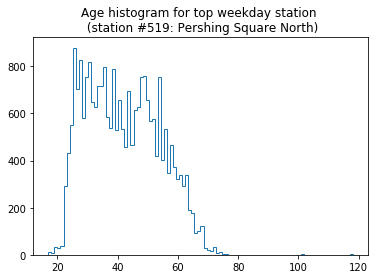

In [194]:
top_station=weekday_subs_trips_df.groupby('start station id')['age'].count().idxmax()

fig = plt.figure()
ax = fig.gca()

age_top_station = weekday_subs_trips_df[weekday_subs_trips_df['start station id']==top_station]['age']

age_top_station.hist(bins=100,histtype='step')
ax.grid(False)

ax.set_title('Age histogram for top weekday station \n (station #{}: {})'.format(top_station,stations_info_df.loc[top_station]['station name']))



Text(0.5, 1.0, 'Age histogram for top weekend station \n (station #435: W 21 St & 6 Ave)')

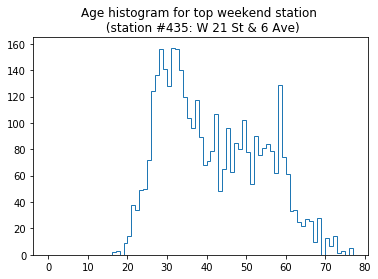

In [195]:
top_station=weekend_subs_trips_df.groupby('start station id')['age'].count().idxmax()

fig = plt.figure()
ax = fig.gca()

age100_df = weekend_subs_trips_df[weekend_subs_trips_df['age']<100]
age_top_station = age100_df[age100_df['start station id']==top_station]['age']

age_top_station.hist(bins=list(range(age100_df[age100_df['start station id']==top_station]['age'].max())),histtype='step')

ax.grid(False)
ax.set_title('Age histogram for top weekend station \n (station #{}: {})'.format(top_station,stations_info_df.loc[top_station]['station name']))


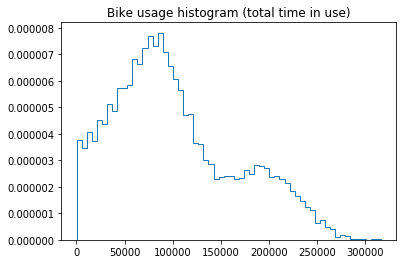

In [201]:
fig = plt.figure()
ax = fig.gca()

total_duration_by_bikeid = weekday_subs_trips_df.groupby('bikeid')['tripduration'].sum()


total_duration_by_bikeid.hist(bins=60,histtype='step',density=True)
ax.grid(False)

ax.set_title('Bike usage histogram (total time in use)');

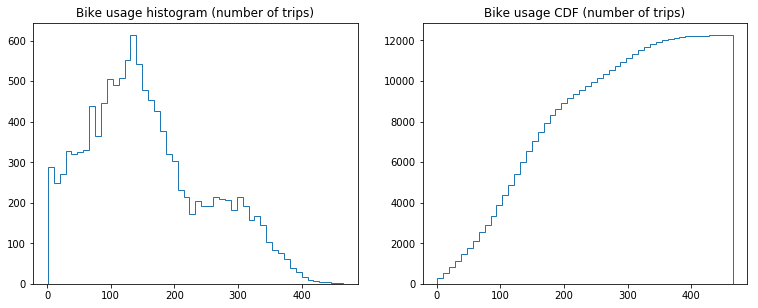

In [203]:
fig = plt.subplots(1,2,figsize=(12.8,4.8))
#ax = fig.gca()

total_trips_by_bikeid = weekday_subs_trips_df.groupby('bikeid')['tripduration'].count()

plt.subplot(121)
total_trips_by_bikeid.hist(bins=50,histtype='step')#,density=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage histogram (number of trips)')

plt.subplot(122)
total_trips_by_bikeid.hist(bins=50,histtype='step',cumulative=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage CDF (number of trips)')

plt.show()



#ax.set_title('Bike usage histogram (total trips)')
#total_trips_by_bikeid.sort_values(ascending=False).head()

In [68]:
#fig = plt.figure()
#ax = fig.gca()

total_duration_by_bikeid.nlargest(10)

#ax.bar(total_duration_by_bikeid.index,total_duration_by_bikeid)
#ax.set_title('Total use by bike')

bikeid
32090    316698
32061    313375
30624    307822
32173    297591
32161    291449
31851    291156
30692    290457
30315    289192
33017    287064
32180    282489
Name: tripduration, dtype: int64

In [ ]:
total_trips_by_hr.nlargest(10)
stations_info_df.loc[519]

In [ ]:
max_total_trips_id
max_single_trip_by_hr

In [134]:
#fig, ax = plt.subplots(nrows=6,ncols=4)
#ax = fig.gca()


duration_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration']

hist_plts = duration_by_hour.hist(bins=144,density=True,histtype='step');


#for row in range(6):
#    for col in range(4):
#        ax[row,col] =  hist_plts[row*4 + col]


#ax.bar(avg_duration_by_hour.index,avg_duration_by_hour,yerr=yerror, ecolor='orange')
#ax.set_title('Trip duration histogram by hour (weekday)')
#ax.legend(labels = list(range(24)),ncol=4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002527029E898>,
      dtype=object)

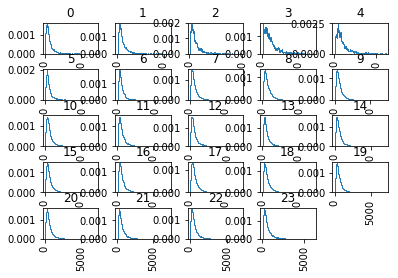

In [200]:
weekday_subs_trips_df.hist(column = 'tripduration', by=weekday_subs_trips_df.pickup_hour, bins = 144,density=True,histtype='step')